In [1]:
import pandas as pd
import numpy as np
import librosa
import cv2
import os
import glob
import seaborn as sns
from tqdm import tqdm
import IPython.display
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.io as pio
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"
import warnings
warnings.simplefilter("ignore")

import cosine_similarity as cs
import freq_dataset as fd
cos = cs.CosineSimilarity()
freq = fd.MakeFreqDataset()

s_path = "../../sounds/"

In [2]:
# 한글 폰트 설정
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

# 한글 사용시 마이너스 폰트가 깨지는 문제가 발생할 수 있으므로 설정 변경
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~')

In [3]:
o_path = list(set(glob.glob(f'{s_path}*/*/*')))
path_ls = [file[3:] for file in o_path if file.endswith(".mp3") or file.endswith(".wav")]
name_ls = [name.split('/')[-1][:-4] for name in path_ls]
label_ls = [name.split('/')[-3] for name in path_ls]
info_df = pd.DataFrame()
info_df['path'] = path_ls
info_df['label'] = label_ls
info_df['name'] = name_ls
info_df

,path,label,name
0,../sounds/human_voice/read_men/jYYHDnEnnDY.079...,human_voice,jYYHDnEnnDY.0798
1,../sounds/human/nose-blowing/XNUL_3_12_0_30_0_...,human,XNUL_3_12_0_30_0_0_0
2,../sounds/human_voice/read_women/3_4158.wav,human_voice,3_4158
3,../sounds/human_voice/read_women/4_2853.wav,human_voice,4_2853
4,../sounds/human_voice/read_women/4_5525.wav,human_voice,4_5525
...,...,...,...
22482,../sounds/human_voice/read_men/nVToV-zn_C4.016...,human_voice,nVToV-zn_C4.0162
22483,../sounds/human_voice/read_women/2_0485.wav,human_voice,2_0485
22484,../sounds/human_voice/read_women/4_5493.wav,human_voice,4_5493
22485,../sounds/human_voice/read_women/4_4681.wav,human_voice,4_4681


In [52]:
o_df = pd.read_csv("../files/freq_dataset_1113.csv", encoding='utf-8-sig')
o_df.drop(["Unnamed: 0", "label"], axis=1, inplace=True)
o_df['cate1'] = [p.split('/')[-3] for p in o_df['path']]
o_df['cate2'] = [p.split('/')[-1][:3] if p.split('/')[-2] == 'cats_dogs' else p.split('/')[-2] for p in o_df['path']]
o_df.drop(o_df[o_df['cate2']=='cats_dog_add_noise'].index, axis=0, inplace=True)
o_df['cate2'] = [c.replace("cat", "고양이") for c in o_df['cate2']]
o_df['cate2'] = [c.replace("dog", "개") for c in o_df['cate2']]
# o_df['cate2'] = [c.replace("까마귀", "새") for c in o_df['cate2']]
o_df['cate2'] = [c.replace(" ", "") for c in o_df['cate2']]
o_df['cate2'] = [c.replace("소리", "") for c in o_df['cate2']]
o_df = o_df[o_df['cate1'] == 'animal'].copy()
o_df

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
1,dr0shorse,../../sounds/animal/말 소리/dr0shorse.wav,1.353651,0.374280,0.095735,0.181595,0.006819,1492.603731,8.567513e+04,955.614463,...,12.378535,56.651711,-10.243791,28.035650,-3.035161,78.115898,1.781476,150.969696,animal,말
8,5-197446-A-7,../../sounds/animal/벌 소리/5-197446-A-7.wav,5.000000,0.459533,0.076533,0.055097,0.002021,2269.844202,1.710596e+05,2555.378258,...,-7.631099,15.183190,-3.202921,17.505238,-8.461825,13.419047,-3.178414,17.566444,animal,벌
38,dog_barking_108,../../sounds/animal/개 소리/dog_barking_108.wav,10.396689,0.659107,0.044288,0.041320,0.001408,3438.614128,9.251955e+05,2171.148015,...,11.429811,33.483120,-13.745112,28.966200,6.268610,26.215820,-7.755744,17.861032,animal,개
39,dog_barking_75,../../sounds/animal/cats_dogs/dog_barking_75.wav,2.593197,0.214954,0.096244,0.114834,0.006668,1103.800057,4.565354e+04,933.097892,...,-9.614342,409.729980,-9.015744,183.782593,0.607754,107.774826,1.981836,255.811737,animal,개
61,bird018,../../sounds/animal/새 소리/bird018.wav,3.007302,0.571848,0.057562,0.010360,0.000108,2694.216571,2.308462e+05,2418.067058,...,-8.622164,23.268013,-0.992545,24.511826,-5.178211,30.655552,-1.723059,18.721495,animal,새
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22397,dog_barking_84,../../sounds/animal/cats_dogs/dog_barking_84.wav,2.332336,0.228779,0.104588,0.075584,0.004076,1115.638823,2.511080e+04,922.167618,...,-6.154753,359.127319,-3.362175,128.277130,-1.667079,201.910492,2.802570,284.567505,animal,개
22442,Haliaeetus_leucocephalus_V2134_12_short,../../sounds/animal/새 소리/Haliaeetus_leucocepha...,6.661224,0.457008,0.097233,0.028743,0.000523,3088.048622,1.189858e+06,2939.443878,...,0.185399,36.920399,0.961222,35.249889,-6.753345,58.879513,4.617588,88.005615,animal,새
22463,4-164064-B-1,../../sounds/animal/닭 소리/4-164064-B-1.wav,5.000000,0.271937,0.133009,0.043096,0.004502,995.322730,1.177301e+06,896.919297,...,1.023258,15.948661,2.904371,40.248821,-3.512716,52.817539,2.830628,44.999092,animal,닭
22466,dog_barking_91,../../sounds/animal/개 소리/dog_barking_91.wav,12.000000,0.378320,0.092914,0.057439,0.005793,1411.745911,1.771185e+05,1335.584895,...,-0.317317,63.718636,-1.498194,45.553402,-3.695013,40.773537,-5.202814,35.384460,animal,개


<BarContainer object of 20 artists>

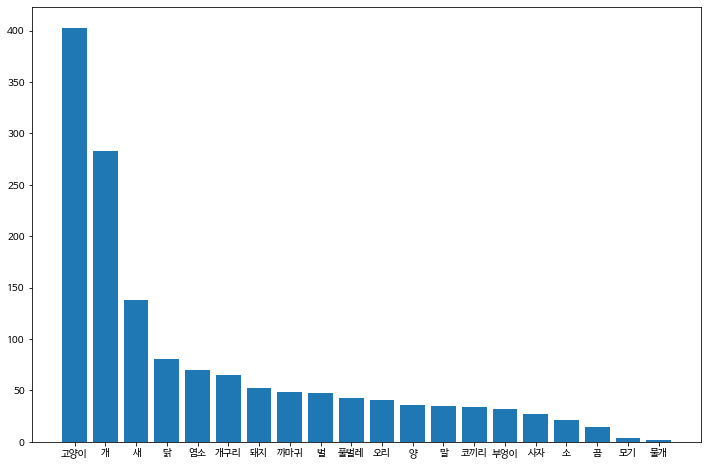

In [53]:
count_df = o_df.groupby('cate2').count().sort_values(by='name', ascending=False)
plt.figure(figsize=(12,8))
plt.bar(count_df.index, height=count_df['name'])

In [54]:
target_animals = ['고양이', '개', '새'] #, '염소','개구리'] # count_df.index[:7].tolist()
print(target_animals)
result_df = pd.DataFrame()
for a in target_animals:
    temp = o_df[o_df['cate2']== a].copy()
    result_df = pd.concat([result_df, temp])
result_df.reset_index(inplace=True, drop=True)
result_df

['고양이', '개', '새']


,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
0,cat_35,../../sounds/animal/고양이 소리/cat_35.wav,11.000000,0.564131,0.067314,0.025919,0.001132,1429.288552,2.612002e+05,1612.312516,...,7.457832,35.269684,-2.501132,24.037781,1.829896,19.635115,1.710906,24.903175,animal,고양이
1,cat_141,../../sounds/animal/고양이 소리/cat_141.wav,0.941723,0.409352,0.080211,0.165388,0.006663,2596.732198,5.135426e+04,1524.065073,...,11.936614,40.342899,-8.426805,32.566399,6.773017,36.244740,-3.884769,35.042721,animal,고양이
2,1-47819-B-5,../../sounds/animal/고양이 소리/1-47819-B-5.wav,5.000000,0.438500,0.095735,0.005553,0.000041,2654.685243,1.751842e+05,2636.130122,...,-6.396316,33.586544,2.215581,33.081585,-8.530169,40.782906,-2.218924,86.056854,animal,고양이
3,cat_6,../../sounds/animal/cats_dogs/cat_6.wav,11.500000,0.675863,0.047439,0.028183,0.001136,1445.259695,5.188685e+05,1818.439417,...,0.885537,54.459682,8.594900,48.064693,6.021374,47.691811,2.553943,34.186470,animal,고양이
4,cat_110,../../sounds/animal/고양이 소리/cat_110.wav,1.272018,0.259342,0.095272,0.171115,0.010512,2171.597309,4.352366e+05,1793.060664,...,-13.009889,199.441040,-16.631609,92.513298,24.283859,269.449158,2.176965,76.417595,animal,고양이
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Podiceps_nigricollis_S1407_08_short,../../sounds/animal/새 소리/Podiceps_nigricollis_...,19.826939,0.499222,0.097981,0.016961,0.001422,2542.965998,1.337441e+06,2305.820309,...,-0.440148,21.321360,3.229295,27.552433,-0.779416,45.752430,2.373824,35.740986,animal,새
820,5-243459-A-14,../../sounds/animal/새 소리/5-243459-A-14.wav,5.000000,0.266685,0.101788,0.036174,0.000845,3942.380489,4.653861e+05,1305.888959,...,5.196290,53.975945,4.467446,74.809502,-1.225562,131.637283,5.190821,58.226742,animal,새
821,bird006,../../sounds/animal/새 소리/bird006.wav,4.031837,0.169760,0.083790,0.024171,0.001215,1499.354852,2.316976e+06,679.320773,...,7.812654,87.415443,-4.891000,40.535492,3.942349,39.711033,-1.278223,24.045929,animal,새
822,bird007,../../sounds/animal/새 소리/bird007.wav,6.827937,0.374876,0.134908,0.087274,0.004589,1637.972320,2.807902e+05,1204.203528,...,8.759885,62.074379,-2.529569,88.179787,9.685721,74.181938,6.483904,83.937576,animal,새


In [55]:
result_df['duration'].describe()

count    824.000000
mean       7.651897
std        6.485924
min        0.570295
25%        3.183231
50%        5.000000
75%       11.800000
max       84.177007
Name: duration, dtype: float64

In [56]:
result_df[result_df['duration']<20].groupby('cate2').count().sort_values(by='name', ascending=False)

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1
cate2,,,,,,,,,,,,,,,,,,,,,
고양이,398,398,398,398,398,398,398,398,398,398,...,398,398,398,398,398,398,398,398,398,398
개,281,281,281,281,281,281,281,281,281,281,...,281,281,281,281,281,281,281,281,281,281
새,115,115,115,115,115,115,115,115,115,115,...,115,115,115,115,115,115,115,115,115,115


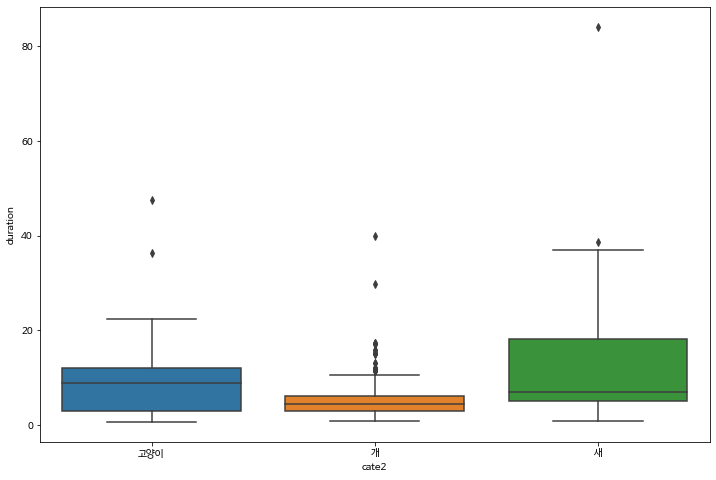

In [57]:
plt.figure(figsize=(12,8))
sns.boxplot(data=result_df, x='cate2', y='duration');

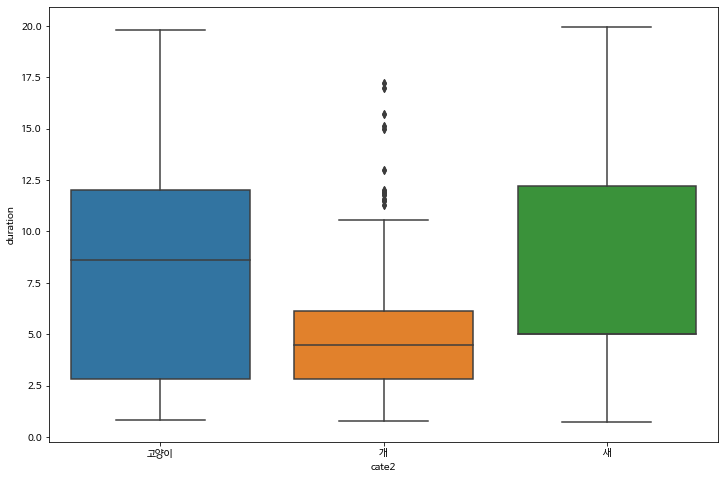

In [58]:
plt.figure(figsize=(12,8))
sns.boxplot(data=result_df[result_df['duration']<20][result_df['duration']>0.7], x='cate2', y='duration');

In [59]:
result_df.groupby('cate2').count()

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1
cate2,,,,,,,,,,,,,,,,,,,,,
개,283,283,283,283,283,283,283,283,283,283,...,283,283,283,283,283,283,283,283,283,283
고양이,403,403,403,403,403,403,403,403,403,403,...,403,403,403,403,403,403,403,403,403,403
새,138,138,138,138,138,138,138,138,138,138,...,138,138,138,138,138,138,138,138,138,138


In [62]:
long_out = result_df[result_df['duration']>20].index.tolist()
short_out = result_df[result_df['duration']<1].index.tolist()
print("너무 긴 outlier 제외: ", len(long_out))
print("너무 짧은 outlier 제외: ", len(short_out))

너무 긴 outlier 제외:  30
너무 짧은 outlier 제외:  22


In [63]:
final_df = result_df.drop(long_out+short_out, axis=0)
final_df

,name,path,duration,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,cate1,cate2
0,cat_35,../../sounds/animal/고양이 소리/cat_35.wav,11.000000,0.564131,0.067314,0.025919,0.001132,1429.288552,2.612002e+05,1612.312516,...,7.457832,35.269684,-2.501132,24.037781,1.829896,19.635115,1.710906,24.903175,animal,고양이
2,1-47819-B-5,../../sounds/animal/고양이 소리/1-47819-B-5.wav,5.000000,0.438500,0.095735,0.005553,0.000041,2654.685243,1.751842e+05,2636.130122,...,-6.396316,33.586544,2.215581,33.081585,-8.530169,40.782906,-2.218924,86.056854,animal,고양이
3,cat_6,../../sounds/animal/cats_dogs/cat_6.wav,11.500000,0.675863,0.047439,0.028183,0.001136,1445.259695,5.188685e+05,1818.439417,...,0.885537,54.459682,8.594900,48.064693,6.021374,47.691811,2.553943,34.186470,animal,고양이
4,cat_110,../../sounds/animal/고양이 소리/cat_110.wav,1.272018,0.259342,0.095272,0.171115,0.010512,2171.597309,4.352366e+05,1793.060664,...,-13.009889,199.441040,-16.631609,92.513298,24.283859,269.449158,2.176965,76.417595,animal,고양이
5,4-133047-A-5,../../sounds/animal/고양이 소리/4-133047-A-5.wav,5.000000,0.373775,0.118681,0.026811,0.000333,1991.122108,8.273883e+05,2159.452713,...,-11.162535,243.101059,-2.757664,143.426208,0.832238,129.783768,7.189624,92.356483,animal,고양이
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Podiceps_nigricollis_S1407_08_short,../../sounds/animal/새 소리/Podiceps_nigricollis_...,19.826939,0.499222,0.097981,0.016961,0.001422,2542.965998,1.337441e+06,2305.820309,...,-0.440148,21.321360,3.229295,27.552433,-0.779416,45.752430,2.373824,35.740986,animal,새
820,5-243459-A-14,../../sounds/animal/새 소리/5-243459-A-14.wav,5.000000,0.266685,0.101788,0.036174,0.000845,3942.380489,4.653861e+05,1305.888959,...,5.196290,53.975945,4.467446,74.809502,-1.225562,131.637283,5.190821,58.226742,animal,새
821,bird006,../../sounds/animal/새 소리/bird006.wav,4.031837,0.169760,0.083790,0.024171,0.001215,1499.354852,2.316976e+06,679.320773,...,7.812654,87.415443,-4.891000,40.535492,3.942349,39.711033,-1.278223,24.045929,animal,새
822,bird007,../../sounds/animal/새 소리/bird007.wav,6.827937,0.374876,0.134908,0.087274,0.004589,1637.972320,2.807902e+05,1204.203528,...,8.759885,62.074379,-2.529569,88.179787,9.685721,74.181938,6.483904,83.937576,animal,새


count    772.000000
mean       7.047615
std        4.533208
min        1.015692
25%        3.356667
50%        5.000000
75%       11.600000
max       19.957551
Name: duration, dtype: float64


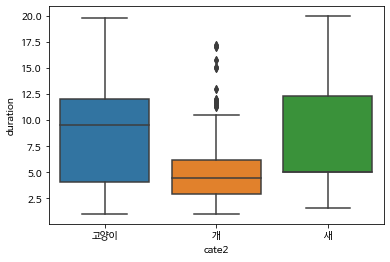

In [64]:
print(final_df['duration'].describe())
sns.boxplot(data=final_df, x='cate2', y='duration');

---
# 분류

In [16]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import pickle
import joblib
import seaborn as sns

In [17]:
def play_song(path):
    (file_dir, file_id) = os.path.split(path)
    print(file_id[:-4])
    print(IPython.display.display(IPython.display.Audio(path)))
def play_song_ls(cm_lr_df):
    for idx, path in enumerate(cm_lr_df['path']):
        print(cm_lr_df['pred'].iloc[idx])
        play_song(path)

In [18]:
def make_train_test(df):
    df = df.sample(frac=1)
    X = df.set_index('path').drop(['name','cate1','cate2','duration'], axis=1)
    y = df.set_index('path')[['cate2']].copy()
    print(f"X 개수:{len(X)}, y 개수:{len(y)}")
    print(df.groupby('cate2').count().sort_values('name')[['name']])
    return X, y

In [19]:
def model_fit_kfold(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cf = confusion_matrix(y_test, y_pred)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    print("accuracy:", round(accuracy_score(y_test, y_pred),6))
    print("recall:", round(recall_score(y_test, y_pred, labels=np.unique(y_test), average='macro'),6))
    print("f1 score:", round(f1_score(y_test, y_pred, labels=np.unique(y_test), average='macro'),6))
#     print("Cross Validation Score:", cross_val_score(model, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=kfold))
    ax = sns.heatmap(cf, annot=True, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), fmt="d", cmap="Blues")
    plt.title(str(model).split('(')[0])
    plt.show()
    return model, y_pred

In [20]:
def check_false_pred(y_pred):
    cm_lr_df = pd.DataFrame()
    cm_lr_df['answer'] = y_test['cate1'].tolist()
    cm_lr_df['pred'] = y_pred
    cm_lr_df['result'] = cm_lr_df['answer'] == cm_lr_df['pred']
    cm_lr_df['path'] = X_test.index
    cm_lr_df['cate2'] = [result_df[result_df['path']== p]['cate2'].iloc[0] for p in cm_lr_df['path']]
#     cm_lr_df['noise'] = [result_df[result_df['path']== p]['noise'].iloc[0] for p in cm_lr_df['path']]
#     cm_lr_df['name'] = [f"{p.split('/')[-2]}__{p.split('/')[-1][:-4]}" for p in cm_lr_df['path']]
#     [l.split('/')[-1]for l in cm_lr_df['path']]
    cm_lr_df = cm_lr_df[cm_lr_df['result']==False].sort_values(['answer', 'cate2'])
    return cm_lr_df

---
# Total songs

### Test dataset 만들기

In [121]:
count_df = final_df.groupby('cate2').count().sort_values(by='name', ascending=False)['name']
count_df

cate2
고양이    379
개      279
새      114
Name: name, dtype: int64

<BarContainer object of 3 artists>

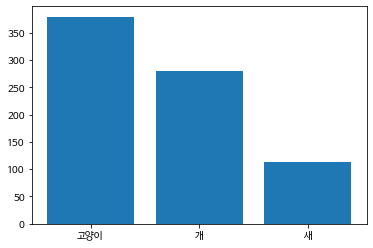

In [122]:
plt.bar(count_df.index, height=count_df)

In [124]:
### random samping으로 라벨별 test 데이터 뽑아두기
test_df = final_df.copy()
test_cat = test_df[test_df['cate2']=='고양이'].sample(n=130, random_state=1)
test_dog = test_df[test_df['cate2']=='개'].sample(n=70, random_state=13)
test_bird = test_df[test_df['cate2']=='새'].sample(n=30, random_state=13)
# test_chicken = test_df[test_df['cate2']=='닭'].sample(n=30, random_state=13)
# test_goat = test_df[test_df['cate2']=='염소'].sample(n=20, random_state=13)
# test_frog = test_df[test_df['cate2']=='개구리'].sample(n=15, random_state=13)
# # test_pig = test_df[test_df['cate2']=='돼지'].sample(n=15, random_state=13)
test_df = pd.concat([test_cat, test_dog, test_bird]) #, test_goat, test_frog])
test_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
새,30
개,70
고양이,130


In [125]:
X_test, y_test = make_train_test(test_df)

X 개수:230, y 개수:230
       name
cate2      
새        30
개        70
고양이     130


In [126]:
train_df = result_df.drop(test_df.index, axis=0)
train_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
새,108
개,213
고양이,273


X 개수:594, y 개수:594
       name
cate2      
새       108
개       213
고양이     273
---------DecisionTreeClassifier---------------
accuracy: 0.86087
recall: 0.836142
f1 score: 0.828314


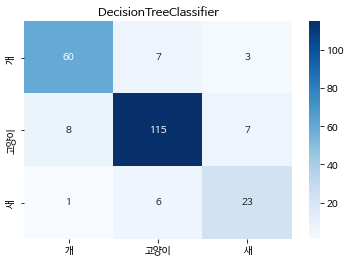

---------XGBClassifier---------------
accuracy: 0.952174
recall: 0.952259
f1 score: 0.945329


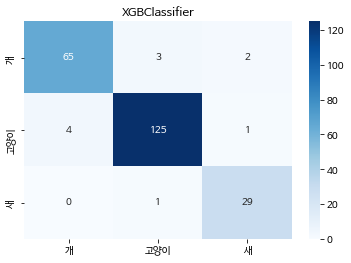

---------RandomForestClassifier---------------
accuracy: 0.913043
recall: 0.873504
f1 score: 0.884295


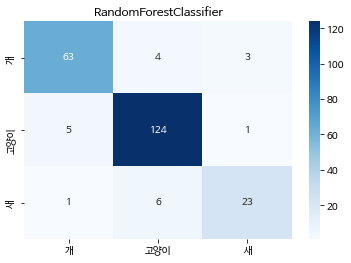

In [129]:
X_train, y_train = make_train_test(train_df)
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------DecisionTreeClassifier---------------
accuracy: 0.882609
recall: 0.861905
f1 score: 0.847274


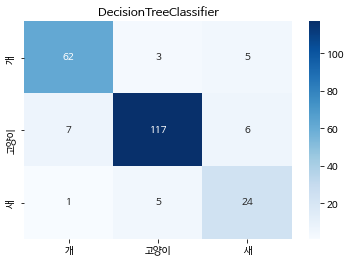

---------RandomForestClassifier---------------
accuracy: 0.913043
recall: 0.873504
f1 score: 0.884295


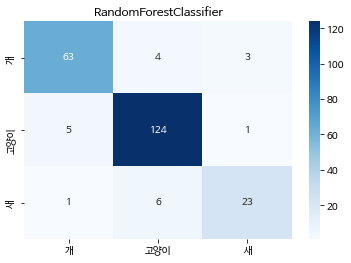

---------XGBClassifier---------------
accuracy: 0.952174
recall: 0.952259
f1 score: 0.945329


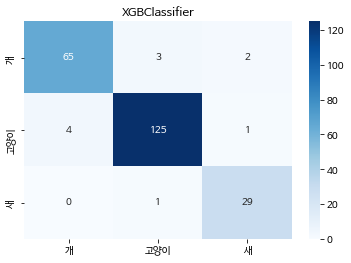

['models/XGB_animal3_90.pkl']

In [130]:
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
# 모델 저장
joblib.dump(xgb_model, 'models/DTC_animal3_86.pkl')
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal3_87.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장
joblib.dump(xgb_model, 'models/XGB_animal3_90.pkl')

### 2. oversamping - imblearn.ADASYN
- SMOTE에 비해 ADASYN이 조금 더 사실적으로 데이터 간의 분산을 넣어 오버샘플링해준다 함

In [131]:
X_test, y_test = make_train_test(test_df)
train_df = result_df.drop(test_df.index, axis=0)
X_train, y_train = make_train_test(train_df)
X_train, y_train = ADASYN(random_state=1).fit_resample(X_train, y_train) # oversamping
y_train.reset_index().groupby('cate2').count()

X 개수:230, y 개수:230
       name
cate2      
새        30
개        70
고양이     130
X 개수:594, y 개수:594
       name
cate2      
새       108
개       213
고양이     273


,index
cate2,
개,285
고양이,273
새,249


---------DecisionTreeClassifier---------------
accuracy: 0.873913
recall: 0.860928
f1 score: 0.851172


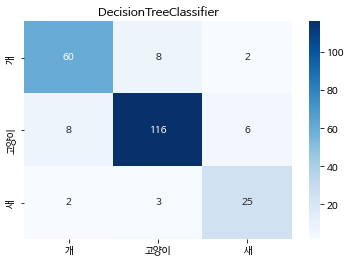

---------XGBClassifier---------------
accuracy: 0.926087
recall: 0.936874
f1 score: 0.910701


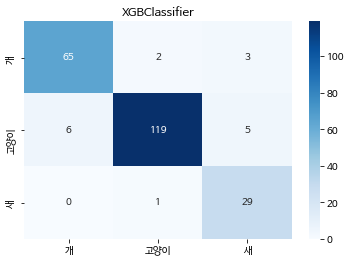

---------RandomForestClassifier---------------
accuracy: 0.904348
recall: 0.855678
f1 score: 0.861336


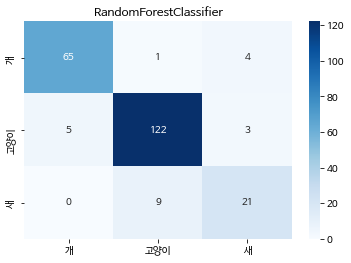

In [132]:
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------DecisionTreeClassifier---------------
accuracy: 0.847826
recall: 0.836996
f1 score: 0.82221


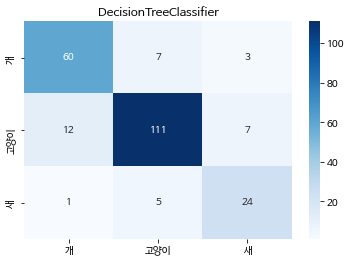

---------RandomForestClassifier---------------
accuracy: 0.904348
recall: 0.855678
f1 score: 0.861336


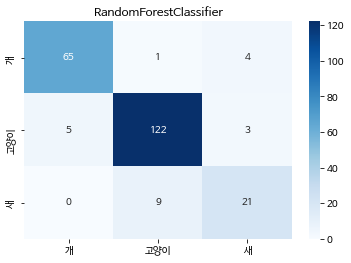

---------XGBClassifier---------------
accuracy: 0.926087
recall: 0.936874
f1 score: 0.910701


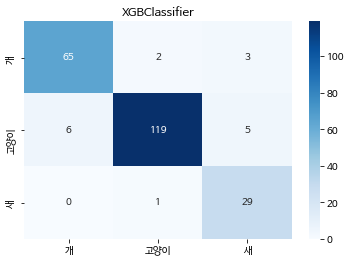

['models/XGB_animal3_oversampling_88.pkl']

In [133]:
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
# 모델 저장
joblib.dump(xgb_model, 'models/DTC_animal3_oversampling_86.pkl')

print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal3_oversampling_89.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장
joblib.dump(xgb_model, 'models/XGB_animal3_oversampling_88.pkl')

---
# short_df
- 노래 길이 백분위 55% 미만 데이터 기준

409
cate2
개      200
고양이    150
새       59
Name: duration, dtype: int64
count    409.000000
mean       3.448443
std        1.396911
min        1.015692
25%        2.108027
50%        3.622449
75%        5.000000
max        5.120000
Name: duration, dtype: float64


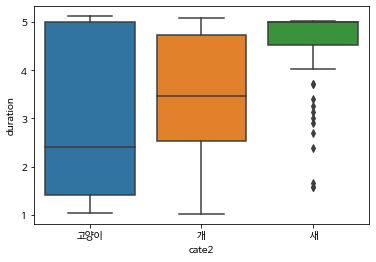

In [88]:
short_df = final_df[final_df['duration']<np.percentile(final_df['duration'], 53)]#[final_df['duration']>np.percentile(final_df['duration'], 25)]
print(len(short_df))
print(short_df.groupby('cate2')['duration'].count())
print(short_df['duration'].describe())
sns.boxplot(data=short_df, x='cate2', y='duration');

## Test dataset 만들기

In [99]:
### random samping으로 라벨별 test 데이터 뽑아두기
test_df = short_df.copy()
test_cat = test_df[test_df['cate2']=='고양이'].sample(n=100, random_state=1)
test_dog = test_df[test_df['cate2']=='개'].sample(n=100, random_state=13)
test_bird = test_df[test_df['cate2']=='새'].sample(n=9, random_state=13)
# test_chicken = test_df[test_df['cate2']=='닭'].sample(n=30, random_state=13)
# test_goat = test_df[test_df['cate2']=='염소'].sample(n=7, random_state=13)
# test_frog = test_df[test_df['cate2']=='개구리'].sample(n=10, random_state=13)
# test_pig = test_df[test_df['cate2']=='돼지'].sample(n=7, random_state=13)
test_df = pd.concat([test_cat, test_dog, test_bird])
test_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
새,9
개,100
고양이,100


In [100]:
X_test, y_test = make_train_test(test_df)

X 개수:209, y 개수:209
       name
cate2      
새         9
개       100
고양이     100


In [101]:
train_df = short_df.drop(test_df.index, axis=0)
train_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
고양이,50
새,50
개,100


### 0. 그대로 테스트

X 개수:200, y 개수:200
       name
cate2      
고양이      50
새        50
개       100
---------DecisionTreeClassifier---------------
accuracy: 0.827751
recall: 0.812593
f1 score: 0.711507


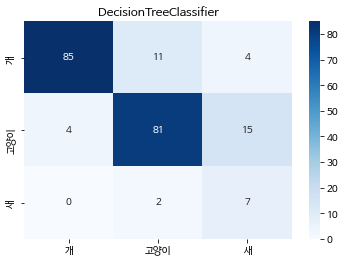

---------XGBClassifier---------------
accuracy: 0.866029
recall: 0.872963
f1 score: 0.782078


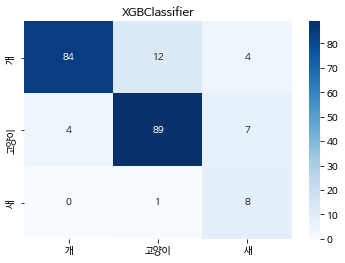

---------RandomForestClassifier---------------
accuracy: 0.818182
recall: 0.83963
f1 score: 0.721935


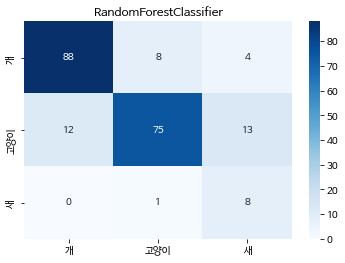

In [103]:
X_train, y_train = make_train_test(train_df)
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------RandomForestClassifier---------------
accuracy: 0.889952
recall: 0.923333
f1 score: 0.880133


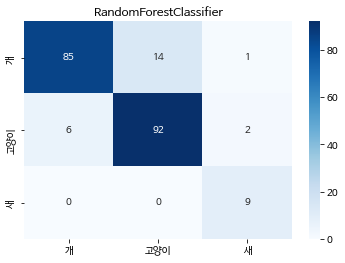

---------XGBClassifier---------------
accuracy: 0.84689
recall: 0.825926
f1 score: 0.7442


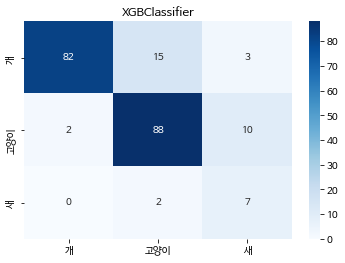

['models/XGB_animal3_under3s_86.pkl']

In [102]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal3_under3s_85.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장
joblib.dump(rf_model, 'models/XGB_animal3_under3s_86.pkl')

### 2. oversamping - imblearn.ADASYN
- SMOTE에 비해 ADASYN이 조금 더 사실적으로 데이터 간의 분산을 넣어 오버샘플링해준다 함

In [96]:
X_test, y_test = make_train_test(test_df)
train_df = short_df.drop(test_df.index, axis=0)
X_train, y_train = make_train_test(train_df)
X_train, y_train = ADASYN(random_state=1).fit_resample(X_train, y_train) # oversamping
y_train.reset_index().groupby('cate2').count()

X 개수:209, y 개수:209
       name
cate2      
새         9
개       100
고양이     100
X 개수:200, y 개수:200
       name
cate2      
고양이      50
새        50
개       100


,index
cate2,
개,100
고양이,100
새,97


---------DecisionTreeClassifier---------------
accuracy: 0.803828
recall: 0.795926
f1 score: 0.704938


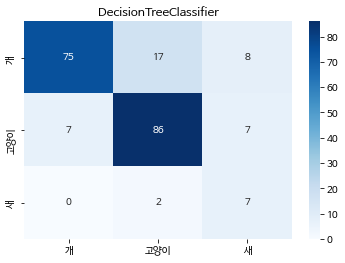

---------XGBClassifier---------------
accuracy: 0.84689
recall: 0.825926
f1 score: 0.7442


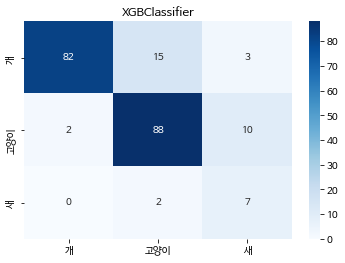

---------RandomForestClassifier---------------
accuracy: 0.889952
recall: 0.923333
f1 score: 0.880133


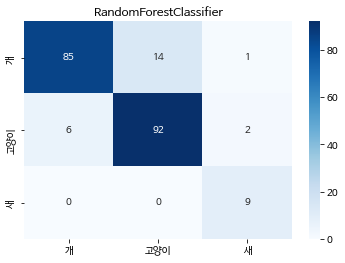

In [97]:
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------RandomForestClassifier---------------
accuracy: 0.889952
recall: 0.923333
f1 score: 0.880133


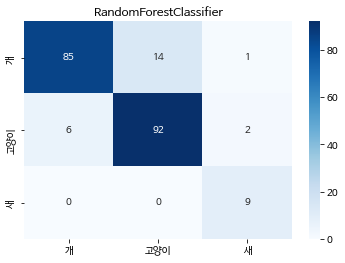

['models/RF_animal3_under3s_oversampling_89.pkl']

In [98]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장
joblib.dump(rf_model, 'models/RF_animal3_under3s_oversampling_89.pkl')

# print("---------XGBClassifier---------------")
# xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
#                                            learning_rate=0.1,
#                                            eval_metric='mlogloss'))
# # 모델 저장
# joblib.dump(rf_model, 'models/XGB_animal6_under3s_oversampling_90.pkl')

---
# long_df
- 노래 길이 백분위 50% 이상 데이터 기준

363
cate1
animal    363
Name: duration, dtype: int64
count    363.000000
mean      11.102882
std        3.231435
min        5.165986
25%        8.930590
50%       11.700000
75%       12.000000
max       19.957551
Name: duration, dtype: float64


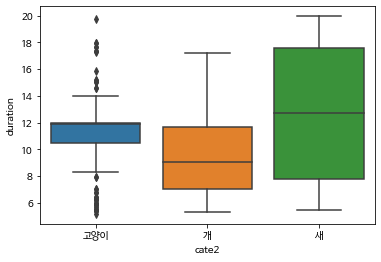

In [104]:
long_df = final_df[final_df['duration']>=np.percentile(final_df['duration'], 53)]#[final_df['duration']<=np.percentile(final_df['duration'], 75)]
print(len(long_df))
print(long_df.groupby('cate1')['duration'].count())
print(long_df['duration'].describe())
sns.boxplot(data=long_df, x='cate2', y='duration');

In [105]:
X, y = make_train_test(long_df)

X 개수:363, y 개수:363
       name
cate2      
새        55
개        79
고양이     229


## Test dataset 만들기

In [116]:
### random samping으로 라벨별 test 데이터 뽑아두기
test_df = long_df.copy()
test_cat = test_df[test_df['cate2']=='고양이'].sample(n=100, random_state=1)
test_dog = test_df[test_df['cate2']=='개'].sample(n=19, random_state=13)
test_bird = test_df[test_df['cate2']=='새'].sample(n=15, random_state=13)
# test_chicken = test_df[test_df['cate2']=='닭'].sample(n=30, random_state=13)
# test_goat = test_df[test_df['cate2']=='염소'].sample(n=15, random_state=13)
# test_frog = test_df[test_df['cate2']=='개구리'].sample(n=9, random_state=13)
# test_pig = test_df[test_df['cate2']=='돼지'].sample(n=8, random_state=13)
test_df = pd.concat([test_cat, test_dog, test_bird])
test_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
새,15
개,19
고양이,100


In [117]:
X_test, y_test = make_train_test(test_df)

X 개수:134, y 개수:134
       name
cate2      
새        15
개        19
고양이     100


In [118]:
train_df = long_df.drop(test_df.index, axis=0)
train_df.groupby('cate2').count().sort_values('name')[['name']]

,name
cate2,
새,40
개,60
고양이,129


### 0. 그대로 테스트

X 개수:229, y 개수:229
       name
cate2      
새        40
개        60
고양이     129
---------DecisionTreeClassifier---------------
accuracy: 0.895522
recall: 0.816257
f1 score: 0.822361


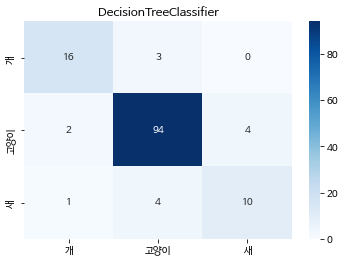

---------XGBClassifier---------------
accuracy: 0.91791
recall: 0.807368
f1 score: 0.830772


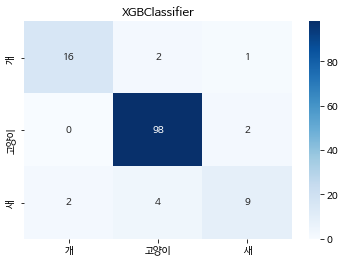

---------RandomForestClassifier---------------
accuracy: 0.895522
recall: 0.77848
f1 score: 0.800563


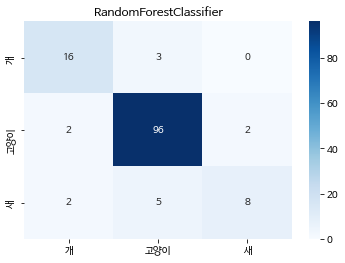

In [119]:
X_train, y_train = make_train_test(train_df)
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------RandomForestClassifier---------------
accuracy: 0.895522
recall: 0.77848
f1 score: 0.800563


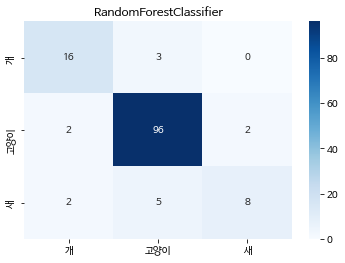

---------XGBClassifier---------------
accuracy: 0.91791
recall: 0.807368
f1 score: 0.830772


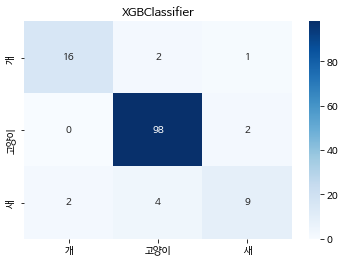

['models/XGB_animal6_over3s_92.pkl']

In [120]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장: 정확도 75
joblib.dump(rf_model, 'models/RF_animal3_over3s_89.pkl')

print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
# 모델 저장: 정확도 75
joblib.dump(rf_model, 'models/XGB_animal6_over3s_92.pkl')

### 2. oversamping - imblearn.ADASYN
- SMOTE에 비해 ADASYN이 조금 더 사실적으로 데이터 간의 분산을 넣어 오버샘플링해준다 함

In [113]:
X_test, y_test = make_train_test(test_df)
train_df = long_df.drop(test_df.index, axis=0)
X_train, y_train = make_train_test(train_df)
X_train, y_train = ADASYN(random_state=13).fit_resample(X_train, y_train) # oversamping
y_train.reset_index().groupby('cate2').count()

X 개수:134, y 개수:134
       name
cate2      
새        15
개        19
고양이     100
X 개수:229, y 개수:229
       name
cate2      
새        40
개        60
고양이     129


,index
cate2,
개,141
고양이,129
새,126


---------DecisionTreeClassifier---------------
accuracy: 0.843284
recall: 0.717368
f1 score: 0.707282


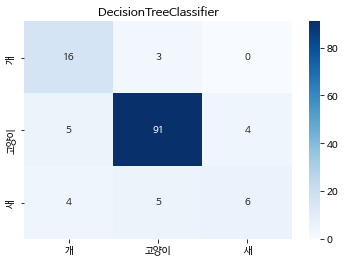

---------XGBClassifier---------------
accuracy: 0.895522
recall: 0.816257
f1 score: 0.805533


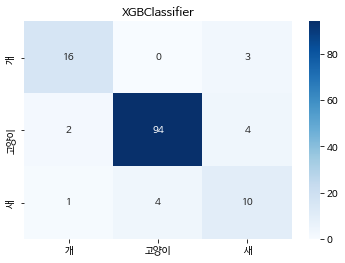

---------RandomForestClassifier---------------
accuracy: 0.902985
recall: 0.814912
f1 score: 0.826352


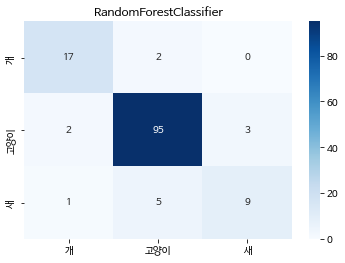

In [114]:
# print("---------LogisticRegression---------------")
# lr_model, lr_y_pred = model_fit_kfold(LogisticRegression())
print("---------DecisionTreeClassifier---------------")
dt_model, dt_y_pred = model_fit_kfold(DecisionTreeClassifier())
print("---------XGBClassifier---------------")
xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
                                           learning_rate=0.1,
                                           eval_metric='mlogloss'))
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))

---------RandomForestClassifier---------------
accuracy: 0.902985
recall: 0.814912
f1 score: 0.826352


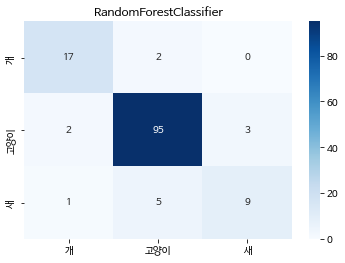

['models/RF_animal3_over3s_oversampling_90.pkl']

In [115]:
print("---------RandomForestClassifier---------------")
rf_model, rf_y_pred = model_fit_kfold(RandomForestClassifier(n_estimators=10, random_state=13, oob_score=True))
# 모델 저장: 정확도 75
joblib.dump(rf_model, 'models/RF_animal3_over3s_oversampling_90.pkl')

# print("---------XGBClassifier---------------")
# xgb_model, xgb_y_pred = model_fit_kfold(XGBClassifier(num_class=5,
#                                            learning_rate=0.1,
#                                            eval_metric='mlogloss'))
# # 모델 저장: 정확도 75
# joblib.dump(rf_model, 'models/XGB_animal6_over3s_oversampling_79.pkl')

---
## 모델 저장하기
- short song
- long song

In [188]:
list(set(glob.glob(f'models/RF_animal6*')))

['models/RF_animal6_under3s_oversampling_83.pkl',
 'models/RF_animal6_over3s_oversampling_75.pkl',
 'models/RF_animal6_80.pkl',
 'models/RF_animal6_under3s_69.pkl']